# Customer Segmentation/Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pmdarima.arima import auto_arima
#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r'C:\Users\KU_0373\Downloads\Retail_Transaction_Dataset 1.csv')
df.head()

CustomerID ProductID  Quantity      Price   TransactionDate PaymentMethod  \
0      109318         C         7  80.079844  12/26/2023 12:32          Cash   
1      993229         C         4  75.195229     8/5/2023 0:00          Cash   
2      579675         A         8  31.528816   3/11/2024 18:51          Cash   
3      799826         D         5  98.880218  10/27/2023 22:00        PayPal   
4      121413         A         7  93.188512  12/22/2023 11:38          Cash   

                                       StoreLocation ProductCategory  \
0            176 Andrew Cliffs\nBaileyfort, HI 93354           Books   
1  11635 William Well Suite 809\nEast Kara, MT 19483      Home Decor   
2  910 Mendez Ville Suite 909\nPort Lauraland, MO...           Books   
3  87522 Sharon Corners Suite 500\nLake Tammy, MO...           Books   
4   0070 Michelle Island Suite 143\nHoland, VA 80142     Electronics   

   DiscountApplied(%)  TotalAmount  
0           18.677100   455.862764  
1           14.121365   258.306546  
2           15.943701   212.015651  
3            6.686337   461.343769  
4            4.030096   626.030484

In [3]:
df.columns

Index(['CustomerID', 'ProductID', 'Quantity', 'Price', 'TransactionDate',
       'PaymentMethod', 'StoreLocation', 'ProductCategory',
       'DiscountApplied(%)', 'TotalAmount'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   CustomerID          100000 non-null  int64  
 1   ProductID           100000 non-null  object 
 2   Quantity            100000 non-null  int64  
 3   Price               100000 non-null  float64
 4   TransactionDate     100000 non-null  object 
 5   PaymentMethod       100000 non-null  object 
 6   StoreLocation       100000 non-null  object 
 7   ProductCategory     100000 non-null  object 
 8   DiscountApplied(%)  100000 non-null  float64
 9   TotalAmount         100000 non-null  float64
dtypes: float64(3), int64(2), object(5)
memory usage: 7.6+ MB


In [5]:
df.describe()

CustomerID       Quantity          Price  DiscountApplied(%)  \
count  100000.000000  100000.000000  100000.000000       100000.000000   
mean   500463.982180       5.009290      55.067344           10.020155   
std    288460.917524       2.579808      25.971567            5.779534   
min        14.000000       1.000000      10.000430            0.000046   
25%    250693.750000       3.000000      32.549474            5.001013   
50%    499679.000000       5.000000      55.116789           10.030353   
75%    751104.750000       7.000000      77.456763           15.018367   
max    999997.000000       9.000000      99.999284           19.999585   

         TotalAmount  
count  100000.000000  
mean      248.334955  
std       184.554792  
min         8.274825  
25%        95.163418  
50%       200.368393  
75%       362.009980  
max       896.141242

In [6]:
df.isna().sum()

CustomerID            0
ProductID             0
Quantity              0
Price                 0
TransactionDate       0
PaymentMethod         0
StoreLocation         0
ProductCategory       0
DiscountApplied(%)    0
TotalAmount           0
dtype: int64

# Exploratory Data Analysis (EDA) for Customer Segmentation

### 1.Analyze the distribution of customers by StoreLocation.

In [7]:
# Convert TransactionDate to datetime
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# Extract the city from StoreLocation
df[['City', 'State']] = df['StoreLocation'].str.extract(r'\n(.*), ([A-Z]{2}) \d{5}', expand=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   CustomerID          100000 non-null  int64         
 1   ProductID           100000 non-null  object        
 2   Quantity            100000 non-null  int64         
 3   Price               100000 non-null  float64       
 4   TransactionDate     100000 non-null  datetime64[ns]
 5   PaymentMethod       100000 non-null  object        
 6   StoreLocation       100000 non-null  object        
 7   ProductCategory     100000 non-null  object        
 8   DiscountApplied(%)  100000 non-null  float64       
 9   TotalAmount         100000 non-null  float64       
 10  City                89194 non-null   object        
 11  State               89194 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(6)
memory usage: 9.2+ MB


In [9]:
df['State'].value_counts().head(10)
# df.groupby('State')['CustomerID'].count().max()

State
ME    1584
OR    1582
MH    1579
AL    1577
MT    1575
IN    1569
FM    1560
SC    1556
TN    1555
AR    1546
Name: count, dtype: int64

In [10]:
df.nunique()

CustomerID             95215
ProductID                  4
Quantity                   9
Price                 100000
TransactionDate        91025
PaymentMethod              4
StoreLocation         100000
ProductCategory            4
DiscountApplied(%)    100000
TotalAmount            99998
City                   35680
State                     59
dtype: int64

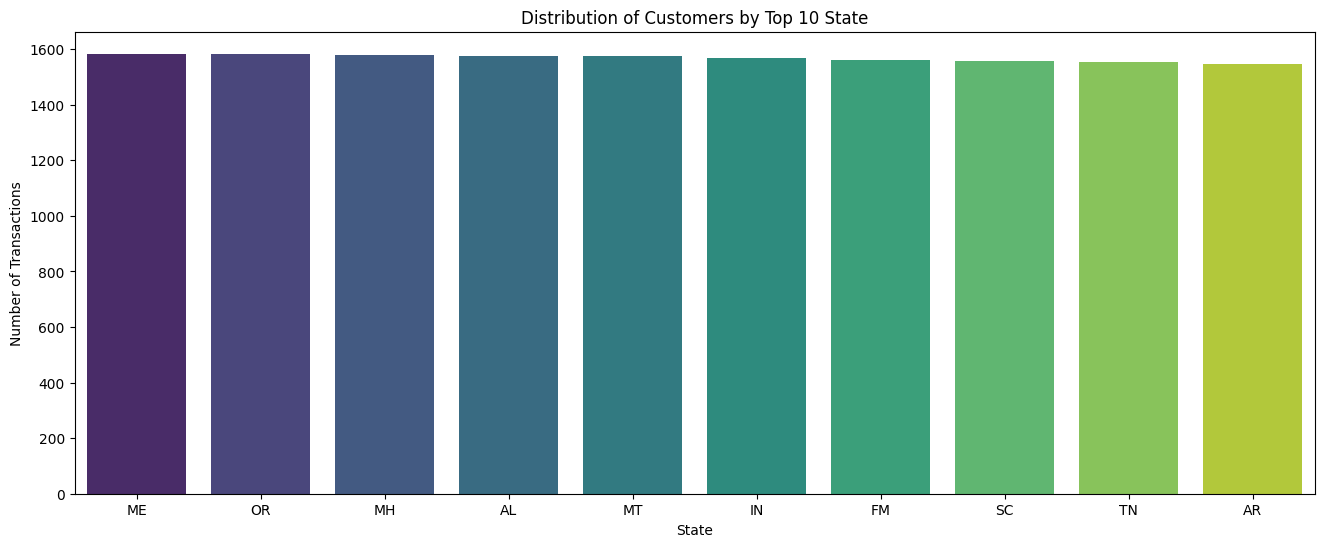

In [11]:
# Distribution of customers across different store locations
state_distribution = df['State'].value_counts().head(10)
# Plotting the distribution of customers across top 10 slocations
plt.figure(figsize=(16, 6))
sns.barplot(x=state_distribution.index, y=state_distribution.values, palette='viridis')
plt.title('Distribution of Customers by Top 10 State')
plt.ylabel('Number of Transactions')
plt.xlabel('State')
plt.show()

#### Observations

In ME state , most of the customers are purchased.

### 2. Can you identify any patterns or trends in purchase behaviour based on customer segments?

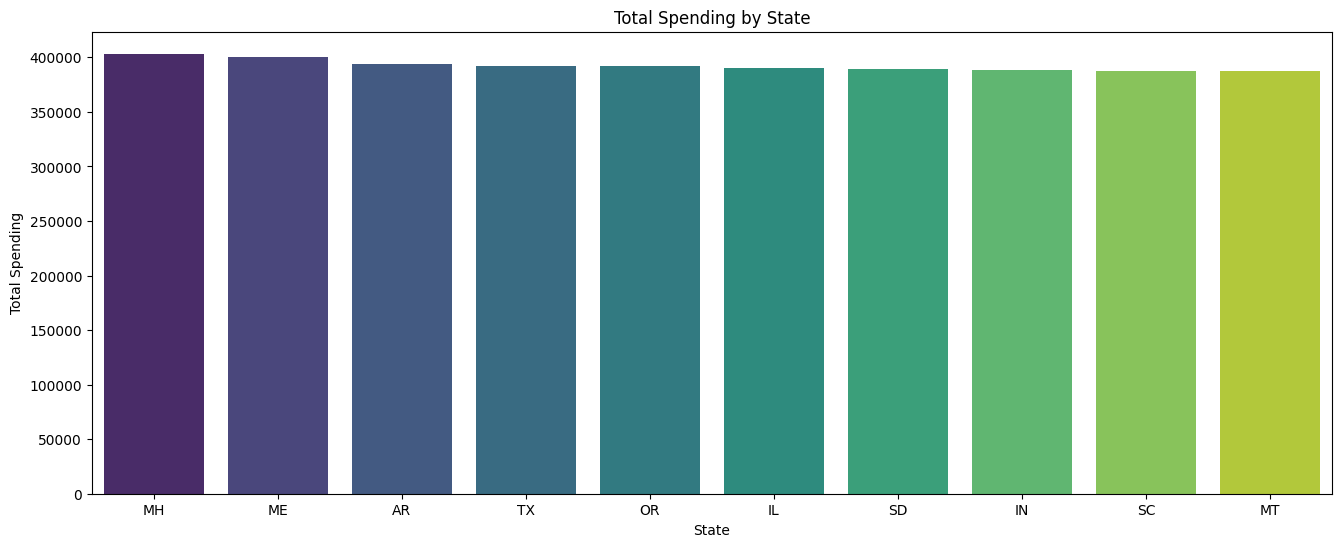

In [12]:
# 1. Total Spending by State
state_spending = df.groupby('State')['TotalAmount'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(16, 6))
sns.barplot(x=state_spending.index, y=state_spending.values, palette='viridis')
plt.title('Total Spending by State')
plt.ylabel('Total Spending')
plt.xlabel('State')
plt.show()

In MH state, customers are spending more money.

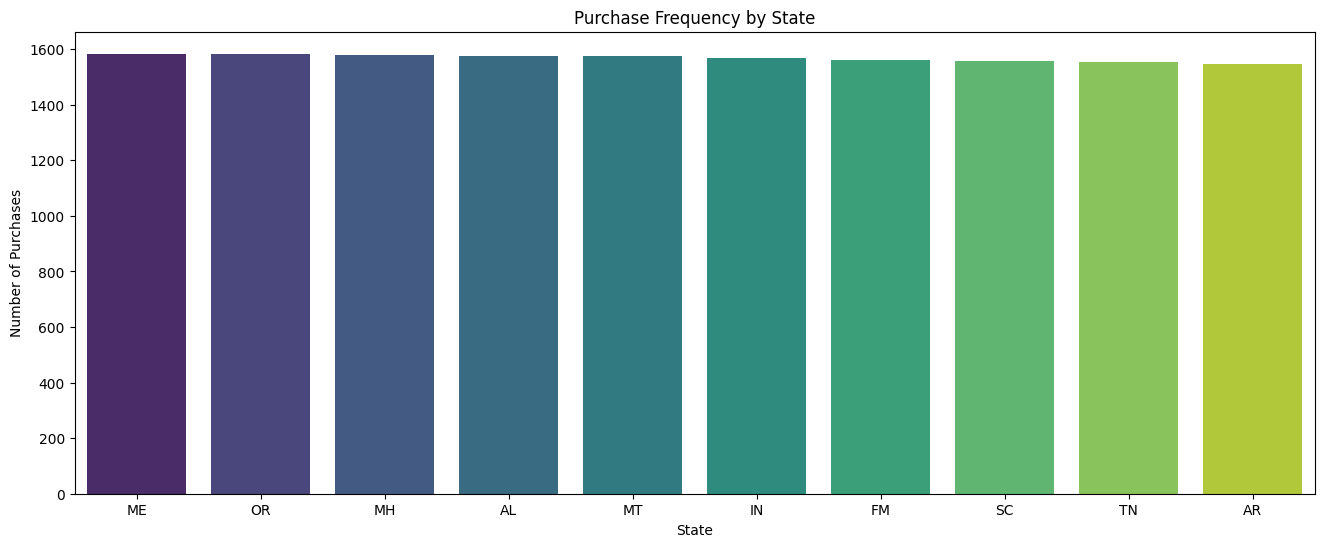

In [13]:
# 2. Purchase Frequency by City
state_purchase_frequency = df.groupby('State')['TransactionDate'].count().sort_values(ascending=False).head(10)
plt.figure(figsize=(16, 6))
sns.barplot(x=state_purchase_frequency.index, y=state_purchase_frequency.values,  palette='viridis')
plt.title('Purchase Frequency by State')
plt.ylabel('Number of Purchases')
plt.xlabel('State')
plt.show()

In ME state, most of the puchases are happend. 

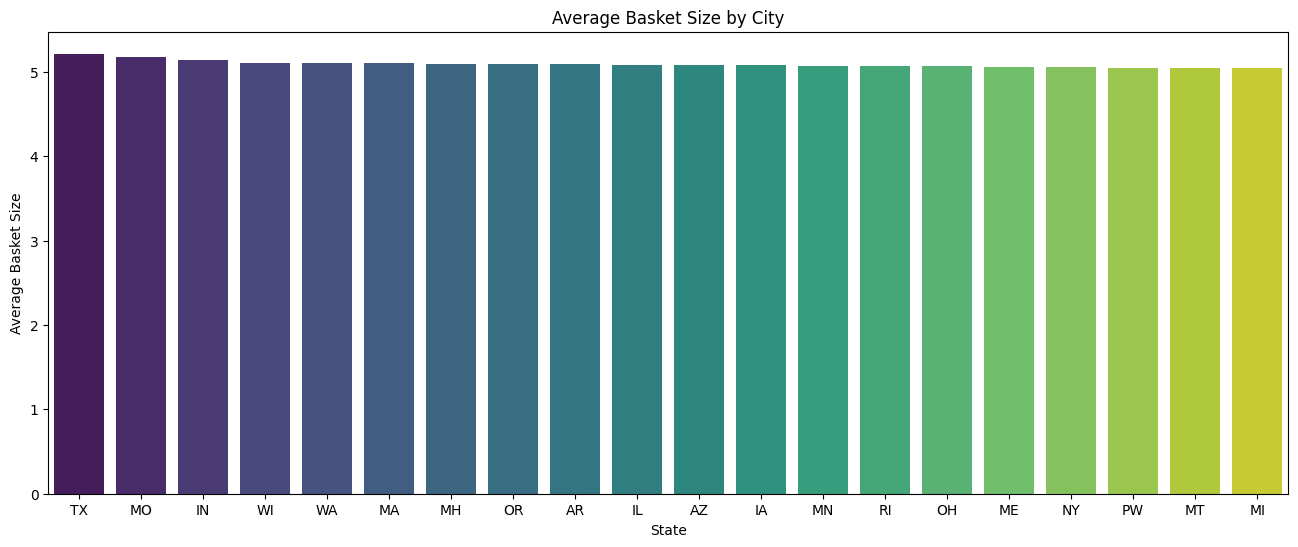

In [14]:
# 3. Average Basket Size by City
state_basket_size = df.groupby('State')['Quantity'].mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(16, 6))
sns.barplot(x=state_basket_size.index, y=state_basket_size.values, palette='viridis')
plt.title('Average Basket Size by City')
plt.ylabel('Average Basket Size')
plt.xlabel('State')
plt.show()

The state with the highest average basket size is 'TX' (Texas) and Certain states like Texas, California, and New York have high average basket sizes

([<matplotlib.patches.Wedge at 0x2c8ec7a0c40>,
 [Text(0.772935182015758, 0.7826692816268358, 'Books'),
  Text(-0.7872113701077781, 0.7683087001804906, 'Clothing'),
  Text(-0.769752556841281, -0.7857995935582498, 'Electronics'),
  Text(0.7812488744985635, -0.7743708388716144, 'Home Decor')],
 [Text(0.4216010083722316, 0.4269105172510013, '25.20%'),
  Text(-0.429388020058788, 0.4190774728257221, '24.99%'),
  Text(-0.41986503100433503, -0.42861796012268166, '24.95%'),
  Text(0.42613574972648915, -0.42238409392997145, '24.86%')])

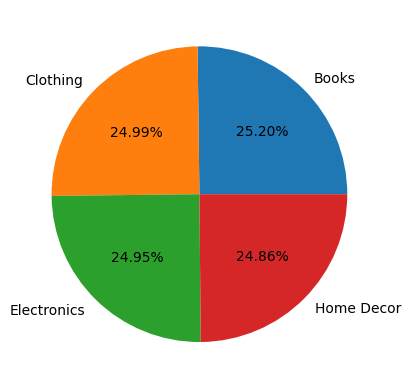

In [15]:
# 4. Total Spending by Product Category
category_spending = df.groupby('ProductCategory')['TotalAmount'].sum().sort_values(ascending=False)
# piechart
plt.pie(category_spending.values, labels = category_spending.index, autopct='%1.2f%%')

Most of the amount is generated in the books category.

([<matplotlib.patches.Wedge at 0x2c8ec751c60>,
 [Text(0.7761785693640061, 0.7794529032982334, 'PayPal'),
  Text(-0.7819117983851159, 0.7737014537572965, 'Credit Card'),
  Text(-0.7726690620815627, -0.7829320024765869, 'Cash'),
  Text(0.7804763417510757, -0.7751494565352273, 'Debit Card')],
 [Text(0.42337012874400326, 0.4251561290717636, '25.07%'),
  Text(-0.42649734457369953, 0.42201897477670713, '25.03%'),
  Text(-0.4214558520444887, -0.42705381953268373, '25.01%'),
  Text(0.4257143682278594, -0.4228087944737603, '24.89%')])

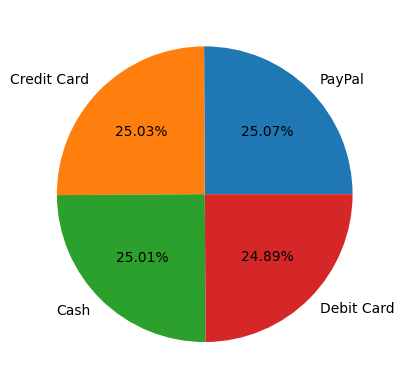

In [16]:
# 5. Payment Method Preferences
payment_method_preference = df['PaymentMethod'].value_counts()
# pie chart
plt.pie(payment_method_preference.values, labels = payment_method_preference.index, autopct='%1.2f%%')

The majority of customers prefer using Paypal, credit cards for of the transactions.

#### 3. How do customer segments differ in terms of average purchase frequency, basket size, and total spending?

In [17]:
# 1. Average Purchase Frequency by State
purchase_frequency_by_state = df.groupby('State')['TransactionDate'].count() / df['CustomerID'].nunique()
# 2. Average Basket Size by State
average_basket_size_by_state = df.groupby('State')['Quantity'].mean()
# 3. Total Spending by State
total_spending_by_state = df.groupby('State')['TotalAmount'].sum()

# 1. Average Purchase Frequency by Product Category
purchase_frequency_by_category = df.groupby('ProductCategory')['TransactionDate'].count() / df['CustomerID'].nunique()
# 2. Average Basket Size by Product Category
average_basket_size_by_category = df.groupby('ProductCategory')['Quantity'].mean()
# 3. Total Spending by Product Category
total_spending_by_category = df.groupby('ProductCategory')['TotalAmount'].sum()

# 1. Average Purchase Frequency by Payment Method
purchase_frequency_by_payment = df.groupby('PaymentMethod')['TransactionDate'].count() / df['CustomerID'].nunique()
# 2. Average Basket Size by Payment Method
average_basket_size_by_payment = df.groupby('PaymentMethod')['Quantity'].mean()
# 3. Total Spending by Payment Method
total_spending_by_payment = df.groupby('PaymentMethod')['TotalAmount'].sum()

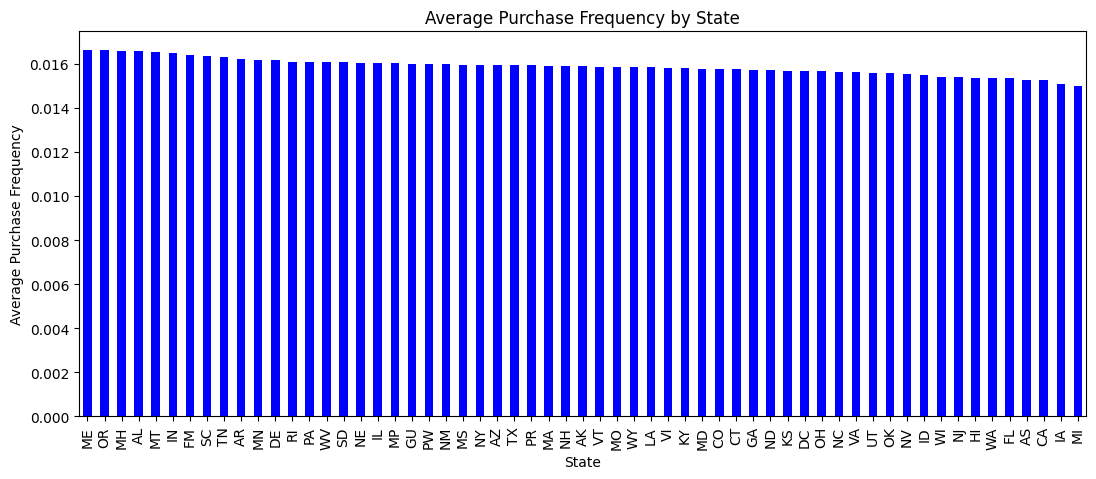

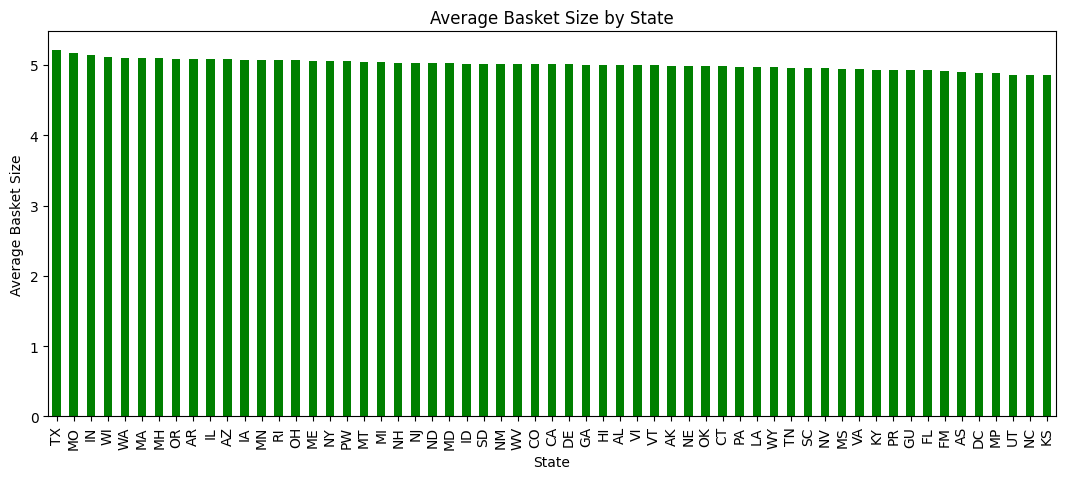

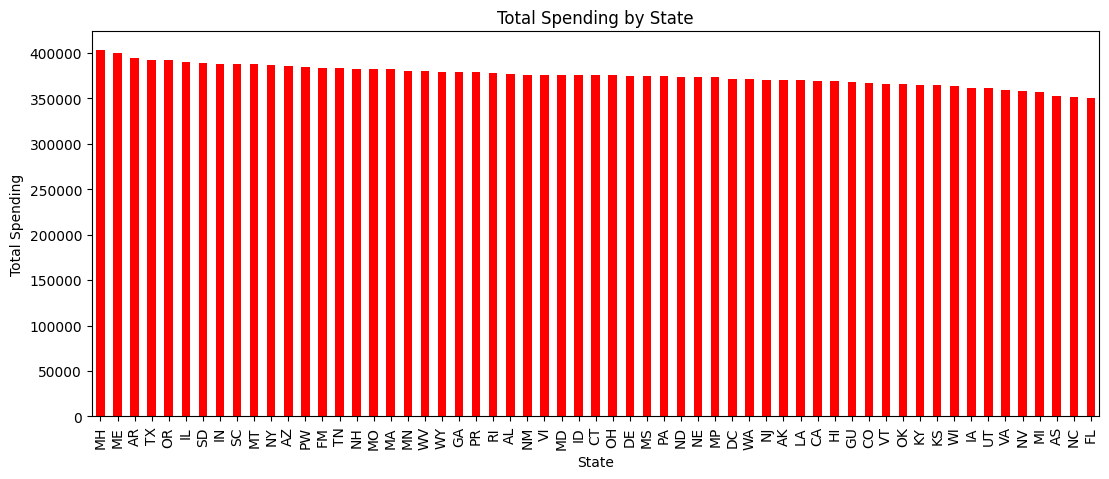

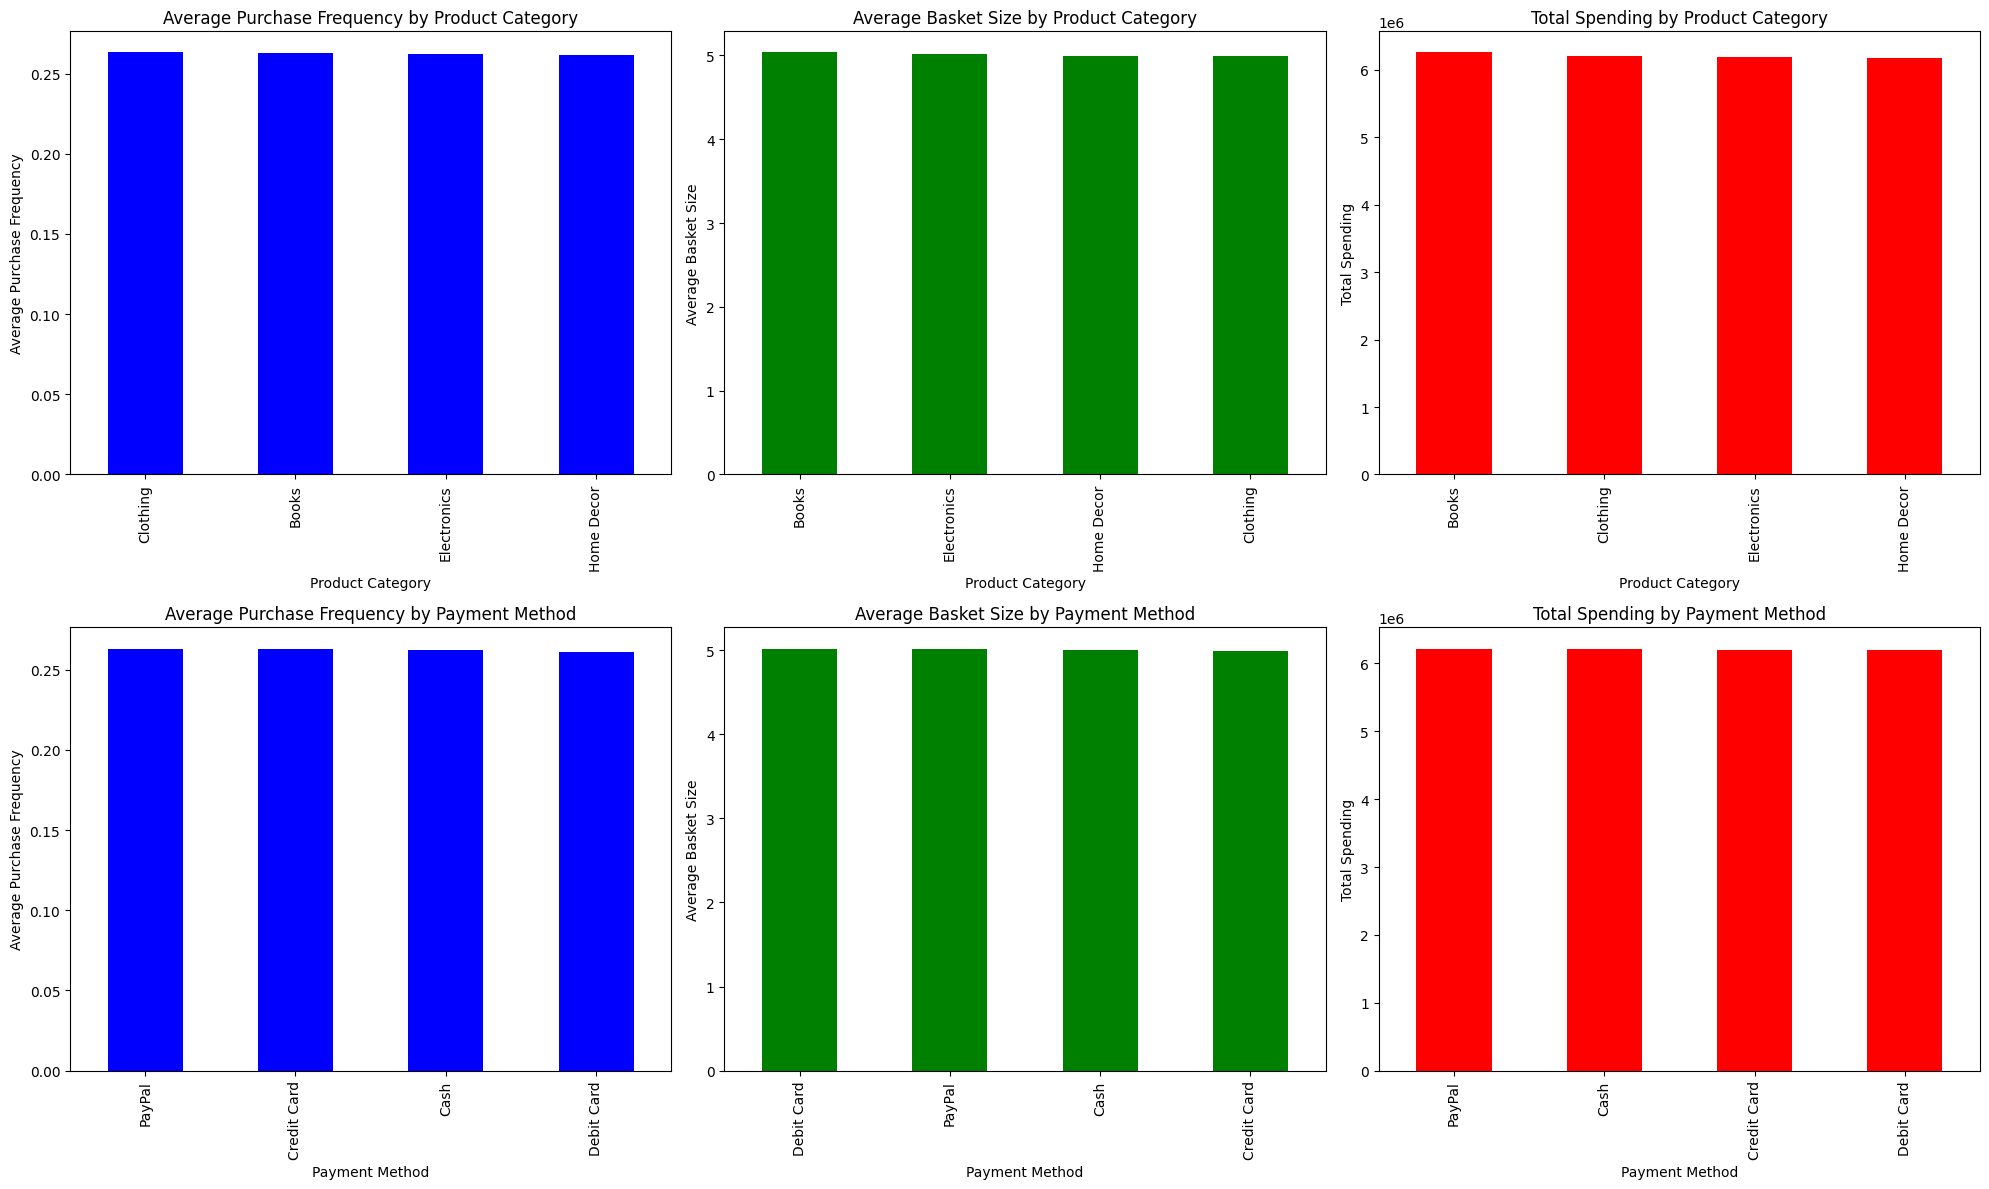

In [18]:
# Plotting the results

plt.figure(figsize=(13,5))
# Average Purchase Frequency by State
# plt.subplot(3, 1, 1)
purchase_frequency_by_state.sort_values(ascending=False).plot(kind='bar', color='blue')
plt.title('Average Purchase Frequency by State')
plt.xlabel('State')
plt.ylabel('Average Purchase Frequency')

# Average Basket Size by State
plt.figure(figsize=(13,5))
average_basket_size_by_state.sort_values(ascending=False).plot(kind='bar', color='green')
plt.title('Average Basket Size by State')
plt.xlabel('State')
plt.ylabel('Average Basket Size')

# Total Spending by State
plt.figure(figsize=(13,5))
total_spending_by_state.sort_values(ascending=False).plot(kind='bar', color='red')
plt.title('Total Spending by State')
plt.xlabel('State')
plt.ylabel('Total Spending')

plt.figure(figsize=(20, 12))
# Average Purchase Frequency by Product Category
plt.subplot(2, 3, 1)
purchase_frequency_by_category.sort_values(ascending=False).plot(kind='bar', color='blue')
plt.title('Average Purchase Frequency by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Average Purchase Frequency')

# Average Basket Size by Product Category
plt.subplot(2, 3, 2)
average_basket_size_by_category.sort_values(ascending=False).plot(kind='bar', color='green')
plt.title('Average Basket Size by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Average Basket Size')

# Total Spending by Product Category
plt.subplot(2, 3, 3)
total_spending_by_category.sort_values(ascending=False).plot(kind='bar', color='red')
plt.title('Total Spending by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Spending')

# Average Purchase Frequency by Payment Method
plt.subplot(2, 3, 4)
purchase_frequency_by_payment.sort_values(ascending=False).plot(kind='bar', color='blue')
plt.title('Average Purchase Frequency by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Average Purchase Frequency')

# Average Basket Size by Payment Method
plt.subplot(2, 3, 5)
average_basket_size_by_payment.sort_values(ascending=False).plot(kind='bar', color='green')
plt.title('Average Basket Size by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Average Basket Size')

# Total Spending by Payment Method
plt.subplot(2, 3, 6)
total_spending_by_payment.sort_values(ascending=False).plot(kind='bar', color='red')
plt.title('Total Spending by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Total Spending')

plt.tight_layout()
plt.show()

1. Average purchage frequency is nothing but how often customers make purchases over a specified period. In ME state Average purchage frequency is high compare to other state.

2. Basket Size refers to the total number of items a customer purchases in a single transaction. In TX, customers are mostly purchasing 5 items.

3. In MH state customers are spending more money compare to other states.

4. In all categories Average purchage frequency is same with small differences.

5. Customers average basket size for books is 5.

6. In all payment method are used by customers for transactions.

7. Customers are purchasing 5 products by all payment methods.

8. Customers are spending the money by using all payment methods.

#### 4. Are there any correlations between customer segments and specific product categories or brands?

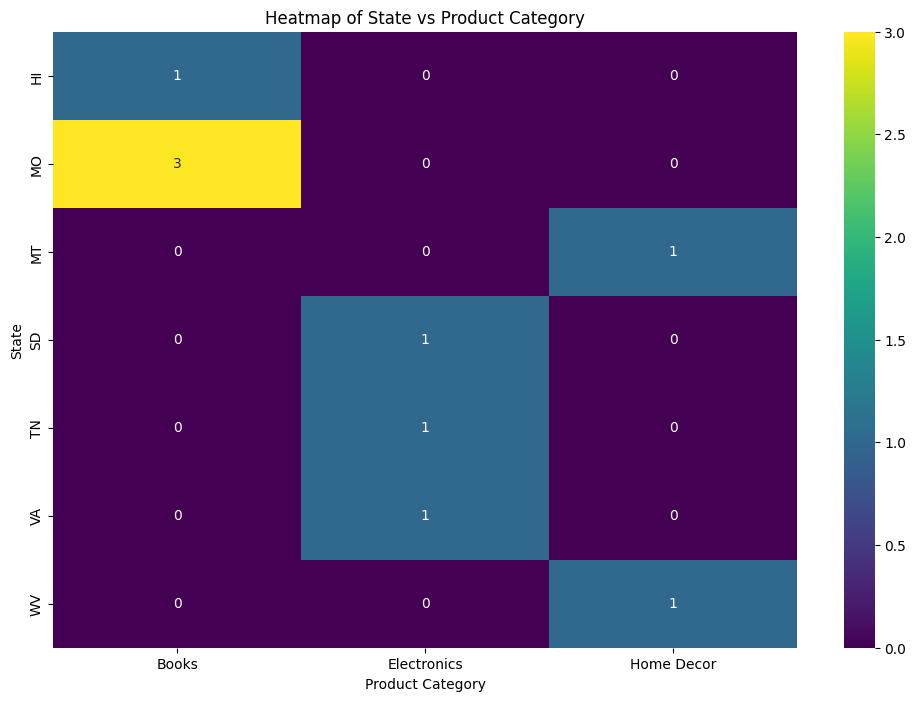

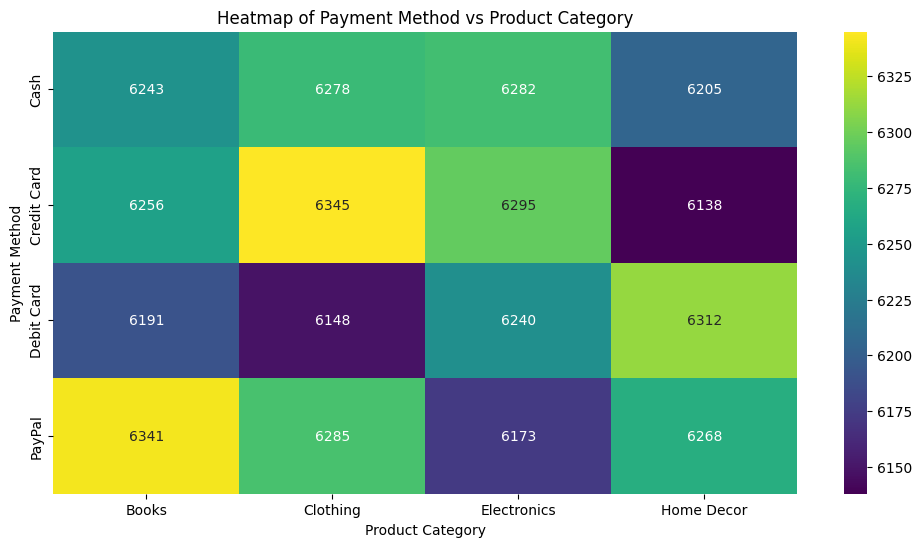

In [19]:
# Cross-tabulation of State and Product Category
state_product_ct = pd.crosstab(df['State'].head(10), df['ProductCategory'])

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(state_product_ct, cmap='viridis', annot=True, fmt='d')
plt.title('Heatmap of State vs Product Category')
plt.xlabel('Product Category')
plt.ylabel('State')
plt.show()

# Cross-tabulation of Payment Method and Product Category
payment_product_ct = pd.crosstab(df['PaymentMethod'], df['ProductCategory'])

# Plotting the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(payment_product_ct, cmap='viridis', annot=True, fmt='d')
plt.title('Heatmap of Payment Method vs Product Category')
plt.xlabel('Product Category')
plt.ylabel('Payment Method')
plt.show()

The heatmaps show the frequency of transactions for each combination of state and product category, and payment method and product category. Darker colors represent higher counts, indicating a stronger association between those segments.

# Recommendations and Actionable Insights:

#### 1. Based on the segmentation analysis, what recommendations can be made to tailor marketing strategies or product offerings to each segment?

##### 1. City Segmentation
Recommendation: Target high-spending cities with personalized marketing campaigns and promotions.

High-Spending Cities: Focus marketing efforts on cities with the highest total spending. For instance, if New York and Los Angeles are top spenders, create exclusive promotions, loyalty programs, and special events in these locations.

##### 2. Product Category Segmentation
Recommendation: Enhance product offerings and marketing strategies for popular product categories.

Top Product Categories: Identify and promote the top-performing product categories. For instance, if electronics and fashion are the highest-grossing categories, consider expanding the product range and offering bundle deals or discounts.

Category-Based Promotions: Run category-specific promotions during peak shopping seasons. For example, promote electronics during the holiday season or fashion items during spring and summer.

##### 3. Payment Method Segmentation
Recommendation: Incentivize preferred payment methods and simplify the checkout process.

Preferred Payment Methods: Identify the most popular payment methods and offer additional incentives for using these methods. For instance, if credit cards and digital wallets are preferred, provide extra rewards points or cash-back offers for transactions made using these methods.

Streamline Checkout: Ensure that the checkout process is seamless and quick for the most used payment methods. Reduce friction points and enhance security features to build customer trust.

##### 4. Average Basket Size Segmentation
Recommendation: Encourage larger basket sizes with upselling and cross-selling techniques.

Upsell and Cross-Sell: Suggest complementary products and higher-end versions of products when customers are shopping. Use recommendation algorithms to show related products that might interest the customer.

Bundle Offers: Create bundle offers and discounts for purchasing multiple items together. For example, offer a discount on accessories when buying a laptop or a special price for a complete outfit in the fashion category.

##### 5. Purchase Frequency Segmentation
Recommendation: Engage frequent shoppers with loyalty programs and personalized experiences.

Loyalty Programs: Develop loyalty programs that reward frequent shoppers with points, discounts, and exclusive offers. Tailor these programs based on the customer’s shopping frequency and spending habits.

Personalized Communication: Use customer data to send personalized emails and messages. For example, send reminders for repeat purchases of consumable goods or personalized recommendations based on previous shopping behavior.

#### 2. How will you track and measure the effectiveness of segmentation-based initiatives over time?

Tracking and measuring the effectiveness of segmentation-based initiatives over time involves setting up key performance indicators (KPIs), using analytics tools, and regularly reviewing and adjusting strategies. Here’s a comprehensive plan for tracking and measuring effectiveness:
##### 1.Sales Metrics:

Total Sales Revenue: Measure overall revenue and revenue per segment.
Average Order Value (AOV): Track changes in the average order value per segment.
Basket Size: Monitor the average number of items per transaction.
##### 2.Customer Metrics:

Customer Lifetime Value (CLV): Calculate the predicted revenue from customers over their lifetime.
Customer Retention Rate: Measure the percentage of repeat customers in each segment.
Customer Acquisition Cost (CAC): Track the cost of acquiring new customers in each segment.
##### 3. Engagement Metrics:

Email Open and Click-Through Rates: Measure engagement with email marketing campaigns.
Website Traffic and Conversion Rates: Track the number of visitors from different segments and their conversion rates.
Social Media Engagement: Monitor likes, shares, comments, and overall engagement on social media platforms.
##### 4. Loyalty and Satisfaction Metrics:

Net Promoter Score (NPS): Gauge customer satisfaction and loyalty.
Customer Satisfaction (CSAT) Scores: Collect feedback on customer satisfaction with products and services.
Churn Rate: Measure the rate at which customers stop doing business with you.
#### Tools and Techniques
##### 1.Customer Relationship Management (CRM) Systems:

Use CRM systems to collect and analyze customer data, track interactions, and segment customers based on behavior and preferences.
##### 2. Web Analytics Tools:

Implement tools like Google Analytics to track website traffic, user behavior, and conversion rates by segment.
Use heatmaps and session recordings to understand how different segments interact with your site.
##### 3. Marketing Automation Platforms:

Use platforms like Mailchimp, HubSpot, or Salesforce to track the effectiveness of email marketing campaigns and customer journeys.
##### 4. Business Intelligence (BI) Tools:

Use BI tools like Tableau, Power BI, or Looker to visualize data, create dashboards, and monitor KPIs in real-time.

#### Regular Review and Adjustment
##### 1. Monthly and Quarterly Reviews:

Conduct regular reviews of KPIs and performance metrics to assess the effectiveness of segmentation strategies.
Identify trends, successes, and areas for improvement.
##### 2. Customer Feedback Loop:

Collect ongoing feedback from customers through surveys, reviews, and direct interactions.
Use this feedback to refine segmentation criteria and tailor marketing efforts.
##### 3. Competitive Analysis:

Monitor competitor strategies and market trends to stay ahead and adjust your segmentation approach accordingly.
##### 4. Adjust Marketing Strategies:

Based on the data and feedback, continuously refine and adjust marketing campaigns, product offerings, and customer engagement strategies to better serve each segment.
#### Reporting and Communication
##### 1. Dashboards:

Create dashboards for real-time tracking of key metrics and share them with relevant stakeholders.
##### 2. Reports:

Generate detailed monthly and quarterly reports highlighting the performance of segmentation-based initiatives.
##### 3. Meetings and Presentations:

Hold regular meetings with marketing, sales, and product teams to discuss insights and strategies based on the segmentation analysis.

#### 3. Are there any potential limitations or biases in the segmentation approach that need to be addressed?

Yes, there are several potential limitations and biases in the segmentation approach that need to be addressed to ensure effective and accurate marketing strategies. Here are some of the key issues:

##### 1. Data Quality and Completeness
Issue: Poor quality or incomplete data can lead to incorrect or misleading segmentation.

Solution: Ensure that the data used for segmentation is clean, accurate, and comprehensive. Implement data cleaning processes and regularly update and validate the data.
##### 2. Over-Segmentation
Issue: Creating too many segments can lead to overly complex strategies that are difficult to manage and execute.

Solution: Balance granularity with manageability. Focus on creating segments that are distinct and actionable, and avoid unnecessary complexity.
##### 3. Dynamic Nature of Customer Behavior
Issue: Customer behavior and preferences can change over time, making static segments less effective.

Solution: Implement a dynamic segmentation approach that regularly updates segments based on the latest data. Use machine learning models to adapt to changing customer behavior in real time.
##### 4. Bias in Data Collection
Issue: Biases in data collection can lead to segments that do not accurately represent the customer base.

Solution: Use diverse and representative data sources. Be aware of potential biases and actively work to mitigate them by including a wide range of demographic and behavioral data.
##### 5. Lack of Actionability
Issue: Segments that are not actionable do not provide clear guidance for marketing strategies.

Solution: Ensure that each segment is meaningful and actionable. Develop clear strategies for how to target each segment effectively.

# Model Selection and Training:

#### 1. What forecasting models will be considered for predicting future sales performance? (e.g., ARIMA, exponential smoothing, machine learning models)

### Check the Stationality by Visual Inception

<Figure size 1600x600 with 0 Axes>

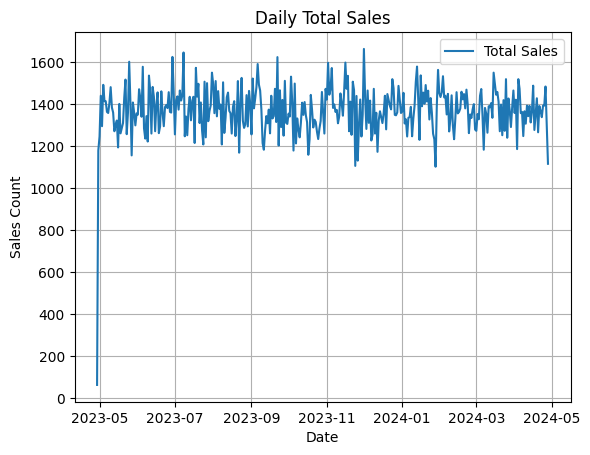

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
# Convert 'TransactionDate' to datetime
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# we add new_colum date in df.
# Extract the date part (without time) to group by date
df['Date'] = df['TransactionDate'].dt.date

# Compute daily sales count

# method-1(how many times the date is repeates that is total sales
# new_df = df.groupby('Date').size().reset_index().rename(columns={0: 'Total Sales'})

# method-2(for each tran , sum of quantity.
new_df = df.groupby('Date')['Quantity'].sum().reset_index().rename(columns={'Quantity': 'Total Sales'})

new_df1 = df.groupby('Date')['Quantity'].sum().reset_index().rename(columns={'Quantity': 'Total Sales'})
new_df.set_index(['Date'], inplace=True)
# Plot the daily sales count
plt.figure(figsize=(16, 6))
new_df.plot()
plt.xlabel('Date')
plt.ylabel('Sales Count')
plt.title('Daily Total Sales')
plt.grid(True)
plt.show()

### Check the Stationality by ADF(Augmented Dickey-Fuller)

In [21]:
from statsmodels.tsa.stattools import adfuller
# Akaike Information Criterion (AIC).
dftest = adfuller(new_df['Total Sales'], autolag = 'AIC') 
# autolag parameter is set to 'AIC', which specifies that the function should automatically select the number of lags 
print("1. ADF : ", dftest[0])
# the main test statistic used in the ADF test. It measures whether the time series is stationary or not.
print("2. P-Value : ", dftest[1])
print("3. Num of Lags : ", dftest[2])
print("4. Num of Observations used for ADF Regression and Critical Values Calculation: ", dftest[3])
print("5. Critical Values : ")
for key, val in dftest[4].items():
    print("\t", key, ":", val)

1. ADF :  -10.997902066600158
2. P-Value :  6.797576178553784e-20
3. Num of Lags :  2
4. Num of Observations used for ADF Regression and Critical Values Calculation:  363
5. Critical Values : 
	 1% : -3.448493650810824
	 5% : -2.8695352280356556
	 10% : -2.5710293341377715


# Observations
- so our data set is stationary. and d is 0

# How to find the order of the AR(p) and MA(q) by using pacf, acf

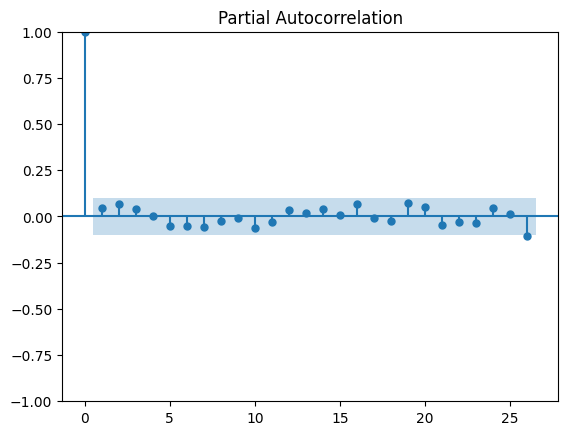

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
pacf = plot_pacf(new_df['Total Sales'])

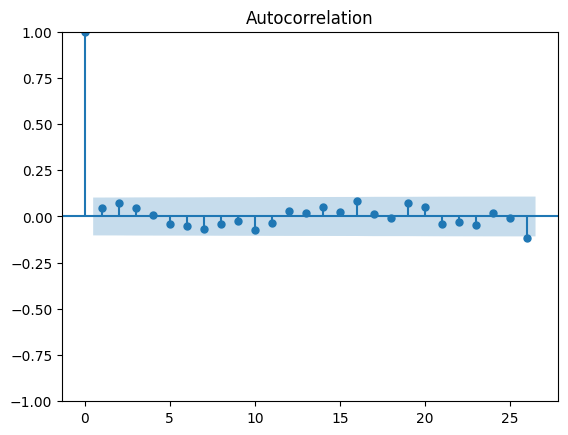

In [23]:
acf = plot_acf(new_df['Total Sales'])

In [24]:
# Split data into train and test sets
sales_data = new_df
split_ratio = 0.8
split_point = int(len(sales_data) * split_ratio)
train_data = sales_data[:split_point]
test_data = sales_data[split_point:]

#### find the order for arima

In [25]:
model = auto_arima(sales_data['Total Sales'], seasonal=False, trace=True, 
                   error_action='ignore', suppress_warnings=True,
                   stepwise=True)

# Print the summary of the model
print(model.summary())

# Fit the best ARIMA model
best_order = model.order
print(f"Optimal order (p, d, q): {best_order}")


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6329.683, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5897.313, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5599.443, Time=0.37 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.80 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=5468.079, Time=0.82 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.56 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=5265.149, Time=0.65 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.72 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=1.13 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=4571.488, Time=1.47 sec
 ARIMA(2,0,5)(0,0,0)[0]             : AIC=inf, Time=1.30 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=0.72 sec
 ARIMA(1,0,5

# Oberservations
from above the plot, we can find the p=2, and q=2

In [26]:
sales_data.head()

Total Sales
Date                   
2023-04-29           62
2023-04-30         1178
2023-05-01         1245
2023-05-02         1439
2023-05-03         1294

In [27]:
train_data.head()

Total Sales
Date                   
2023-04-29           62
2023-04-30         1178
2023-05-01         1245
2023-05-02         1439
2023-05-03         1294

In [28]:
test_data.head()

Total Sales
Date                   
2024-02-15         1355
2024-02-16         1362
2024-02-17         1378
2024-02-18         1458
2024-02-19         1422

In [29]:
test_data.tail()

Total Sales
Date                   
2024-04-24         1392
2024-04-25         1392
2024-04-26         1483
2024-04-27         1301
2024-04-28         1115

# ARIMA

ARIMA stands for Auto-Regressive Integrated Moving Average. There are three integers (p, d, q) that are used to parametrize ARIMA models. Because of that, a nonseasonal ARIMA model is denoted with ARIMA(p, d, q):

In [30]:
# arima(predict the test_data) and plot the true test_data and predicted_test_data
# before that we need to install the pmdarima module.

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt

# Fit ARIMA model
model_arima = ARIMA(train_data['Total Sales'], order=(6,0,6))
results_arima = model_arima.fit()
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Total Sales   No. Observations:                  292
Model:                 ARIMA(6, 0, 6)   Log Likelihood               -1827.346
Date:                Sun, 16 Jun 2024   AIC                           3682.691
Time:                        16:52:59   BIC                           3734.166
Sample:                    04-29-2023   HQIC                          3703.310
                         - 02-14-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1369.0596      6.978    196.208      0.000    1355.384    1382.735
ar.L1         -0.0938      0.018     -5.212      0.000      -0.129      -0.059
ar.L2          0.4034      0.013     31.965      0.000       0.379       0.428
ar.L3          0.0228      0.025      0.917      0.359      -0.026       0.072
ar.L4          0.4048      0.012     32.658      0.000       0.380       0.429
ar.L5         -0.1006      0.021     -4.809      0.000      -0.142      -0.060
ar.L6         -0.9951      0.012    -83.125      0.000      -1.019      -0.972
ma.L1          0.1376      0.073      1.877      0.061      -0.006       0.281
ma.L2         -0.4052      0.057     -7.085      0.000      -0.517      -0.293
ma.L3         -0.0468      0.021     -2.258      0.024      -0.087      -0.006
ma.L4         -0.4010      0.054     -7.474      0.000      -0.506      -0.296
ma.L5          0.1261      0.076      1.655      0.098      -0.023       0.275
ma.L6          0.9779      0.049     20.027      0.000       0.882       1.074
sigma2      1.258e+04      0.006   2.09e+06      0.000    1.26e+04    1.26e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):               671.46
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                            -1.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.87e+22. Standard errors may be unstable.
"""

#### predict the test_data

2024-02-15    1403.007089
2024-02-16    1366.461010
2024-02-17    1425.346388
2024-02-18    1411.714175
2024-02-19    1409.459975
                 ...     
2024-04-24    1335.454433
2024-04-25    1371.319900
2024-04-26    1299.604837
2024-04-27    1345.025094
2024-04-28    1368.153358
Freq: D, Name: predicted_mean, Length: 74, dtype: float64


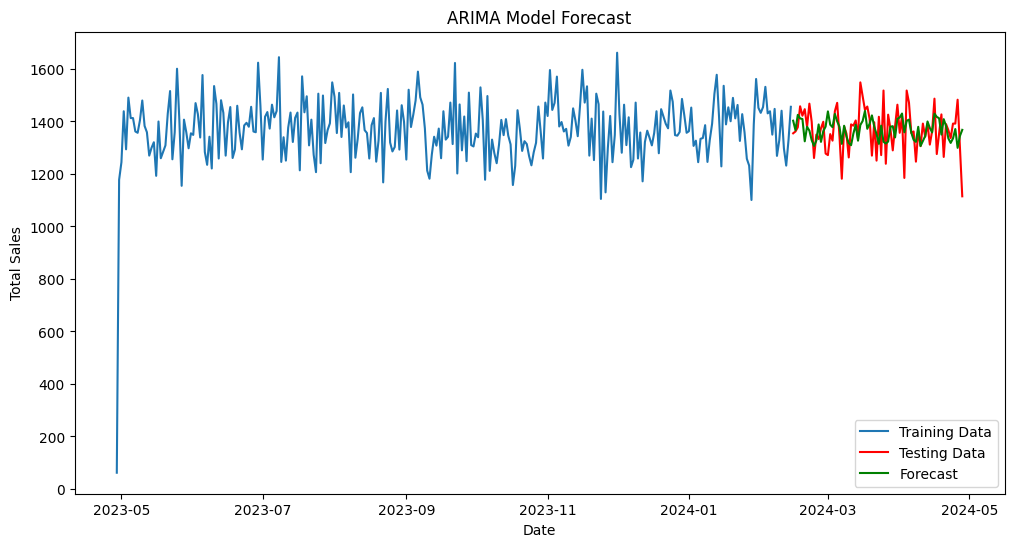

In [31]:
# Forecast for testing data, predictred_test_data is forecast_arima
start=len(train_data)
end=len(train_data) + len(test_data)-1
pred = results_arima.predict(start=start, end=end, type='levels')
print(pred)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train_data['Total Sales'], label='Training Data')
plt.plot(test_data['Total Sales'], label='Testing Data', color='red')
plt.plot(pred.index, pred.values, label='Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

In [32]:
# predicted_test_data
pred

2024-02-15    1403.007089
2024-02-16    1366.461010
2024-02-17    1425.346388
2024-02-18    1411.714175
2024-02-19    1409.459975
                 ...     
2024-04-24    1335.454433
2024-04-25    1371.319900
2024-04-26    1299.604837
2024-04-27    1345.025094
2024-04-28    1368.153358
Freq: D, Name: predicted_mean, Length: 74, dtype: float64

In [33]:
# actual test data
test_data

Total Sales
Date                   
2024-02-15         1355
2024-02-16         1362
2024-02-17         1378
2024-02-18         1458
2024-02-19         1422
...                 ...
2024-04-24         1392
2024-04-25         1392
2024-04-26         1483
2024-04-27         1301
2024-04-28         1115

[74 rows x 1 columns]

#### Calculate Metrics

In [34]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Assume y_true and y_pred are the actual and predicted values respectively
y_true = test_data['Total Sales']
y_pred = pred  # Replace with the predictions from your model

# Calculate MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate MSE
mse = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate MAPE
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%')


Mean Absolute Error (MAE): 63.27316674572936
Mean Squared Error (MSE): 6977.37695464809
Root Mean Squared Error (RMSE): 83.53069468553515
Mean Absolute Percentage Error (MAPE): 4.71%


#### Forecasting feature sales by Using ARIMA

2024-04-29    1371.638225
2024-04-30    1356.569178
2024-05-01    1385.606842
2024-05-02    1400.346642
2024-05-03    1384.326683
2024-05-04    1363.370931
2024-05-05    1383.003749
2024-05-06    1387.208767
2024-05-07    1360.104153
2024-05-08    1341.338951
2024-05-09    1361.067396
2024-05-10    1368.601386
2024-05-11    1346.105904
2024-05-12    1341.774077
2024-05-13    1371.165513
2024-05-14    1384.175904
2024-05-15    1365.516003
2024-05-16    1366.630676
2024-05-17    1394.047856
2024-05-18    1397.503461
2024-05-19    1370.155514
2024-05-20    1365.269626
2024-05-21    1384.119849
2024-05-22    1376.969311
2024-05-23    1346.463221
2024-05-24    1345.207797
2024-05-25    1367.761326
2024-05-26    1363.878716
2024-05-27    1342.944170
2024-05-28    1354.142263
Freq: D, Name: Arima Feature sales Prediction, dtype: float64


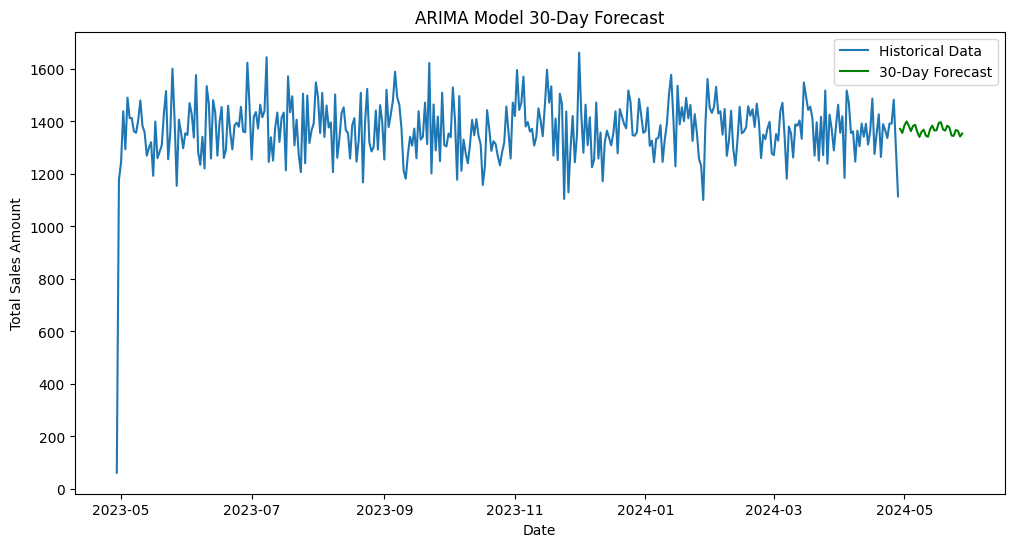

In [35]:
model_arima = ARIMA(sales_data['Total Sales'], order=(6,0,6))
results_arima2 = model_arima.fit()

index_feature_dates = pd.date_range(start='2024-04-29', end='2024-05-28')
pred = results_arima2.predict(start=len(sales_data), end=len(sales_data) + 29, type='levels').rename('Arima Feature sales Prediction')
pred.index=index_feature_dates
print(pred)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(sales_data['Total Sales'], label='Historical Data')
plt.plot(index_feature_dates, pred, label='30-Day Forecast', color='green')
# plt.fill_between(forecast_dates, forecast_arima_ci.iloc[:, 0], forecast_arima_ci.iloc[:, 1], color='green', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.title('ARIMA Model 30-Day Forecast')
plt.legend()
plt.show()

In [36]:
# forecasting 30 sales by arima
pred

2024-04-29    1371.638225
2024-04-30    1356.569178
2024-05-01    1385.606842
2024-05-02    1400.346642
2024-05-03    1384.326683
2024-05-04    1363.370931
2024-05-05    1383.003749
2024-05-06    1387.208767
2024-05-07    1360.104153
2024-05-08    1341.338951
2024-05-09    1361.067396
2024-05-10    1368.601386
2024-05-11    1346.105904
2024-05-12    1341.774077
2024-05-13    1371.165513
2024-05-14    1384.175904
2024-05-15    1365.516003
2024-05-16    1366.630676
2024-05-17    1394.047856
2024-05-18    1397.503461
2024-05-19    1370.155514
2024-05-20    1365.269626
2024-05-21    1384.119849
2024-05-22    1376.969311
2024-05-23    1346.463221
2024-05-24    1345.207797
2024-05-25    1367.761326
2024-05-26    1363.878716
2024-05-27    1342.944170
2024-05-28    1354.142263
Freq: D, Name: Arima Feature sales Prediction, dtype: float64

# FB Prophet

In [37]:
#install Prophet from fbprophet. 
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet

In [38]:
new_df1.head()

Date  Total Sales
0  2023-04-29           62
1  2023-04-30         1178
2  2023-05-01         1245
3  2023-05-02         1439
4  2023-05-03         1294

#### change the column Names for FB Prophet

In [39]:
new_df1.columns = ['ds', 'y']

In [40]:
new_df1.tail()

ds     y
361  2024-04-24  1392
362  2024-04-25  1392
363  2024-04-26  1483
364  2024-04-27  1301
365  2024-04-28  1115

#### Plot your data

<Axes: xlabel='ds'>

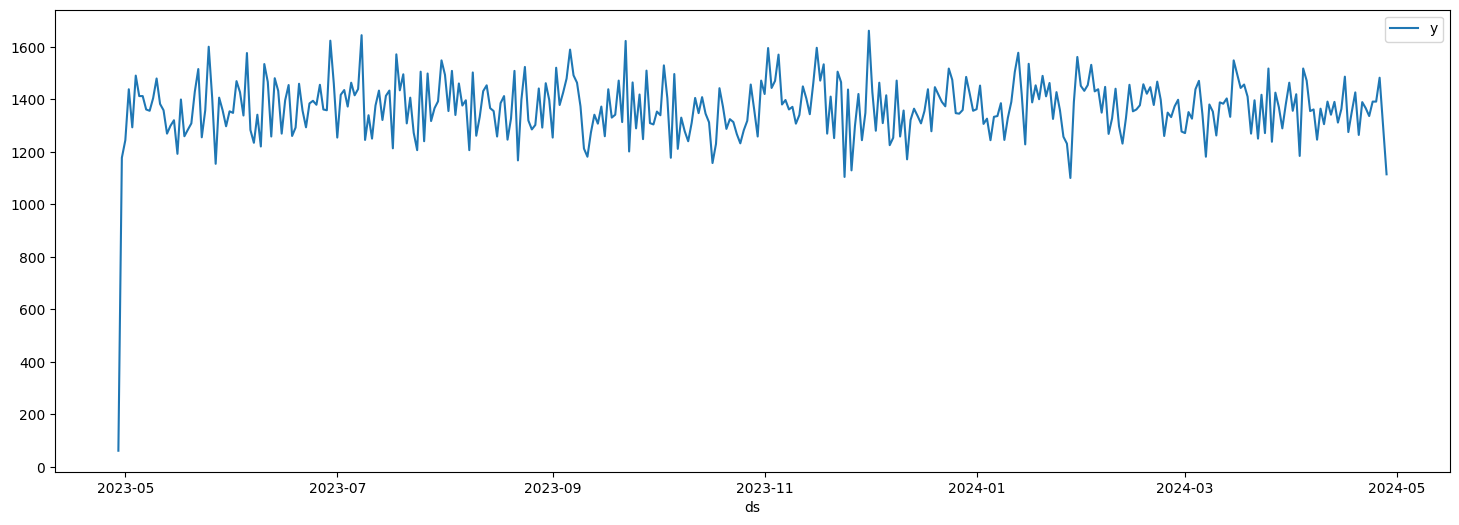

In [41]:
new_df1.plot(x='ds', y='y', figsize=(18,6))

#### Split dataset into train_data and test_data

In [42]:
train = new_df1.iloc[:len(new_df1)-100]
test = new_df1.iloc[len(new_df1) - 100:]
# train - 266 and test - 100

In [43]:
len(test)

100

In [44]:
train.tail()

ds     y
261  2024-01-15  1229
262  2024-01-16  1536
263  2024-01-17  1389
264  2024-01-18  1454
265  2024-01-19  1401

In [45]:
test.tail()

ds     y
361  2024-04-24  1392
362  2024-04-25  1392
363  2024-04-26  1483
364  2024-04-27  1301
365  2024-04-28  1115

#### Start Making predictions

In [46]:
# CREATE A MODEL
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=100) #66 is original but i gave 90
forecast = m.predict(future)
# actually it gives 66 prediction

16:53:02 - cmdstanpy - INFO - Chain [1] start processing
16:53:03 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
forecast.tail()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
361 2024-04-24  1379.721093  1219.328573  1543.882378  1371.610649   
362 2024-04-25  1379.750532  1253.480873  1581.166883  1371.486203   
363 2024-04-26  1379.779971  1213.769818  1545.983795  1371.401013   
364 2024-04-27  1379.809410  1216.264139  1538.187800  1371.300983   
365 2024-04-28  1379.838848  1214.154964  1528.930212  1371.193516   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
361  1387.464421        4.385565              4.385565              4.385565   
362  1387.582105       36.916344             36.916344             36.916344   
363  1387.761826        9.150955              9.150955              9.150955   
364  1387.910594      -17.522399            -17.522399            -17.522399   
365  1388.041688      -11.540974            -11.540974            -11.540974   

        weekly  weekly_lower  weekly_upper  multiplicative_terms  \
361   4.385565      4.385565      4.385565                   0.0   
362  36.916344     36.916344     36.916344                   0.0   
363   9.150955      9.150955      9.150955                   0.0   
364 -17.522399    -17.522399    -17.522399                   0.0   
365 -11.540974    -11.540974    -11.540974                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper         yhat  
361                         0.0                         0.0  1384.106658  
362                         0.0                         0.0  1416.666876  
363                         0.0                         0.0  1388.930926  
364                         0.0                         0.0  1362.287011  
365                         0.0                         0.0  1368.297875

In [48]:
# prediction of test
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower   yhat_upper
361 2024-04-24  1384.106658  1219.328573  1543.882378
362 2024-04-25  1416.666876  1253.480873  1581.166883
363 2024-04-26  1388.930926  1213.769818  1545.983795
364 2024-04-27  1362.287011  1216.264139  1538.187800
365 2024-04-28  1368.297875  1214.154964  1528.930212

In [49]:
# acutal
test.tail()

ds     y
361  2024-04-24  1392
362  2024-04-25  1392
363  2024-04-26  1483
364  2024-04-27  1301
365  2024-04-28  1115

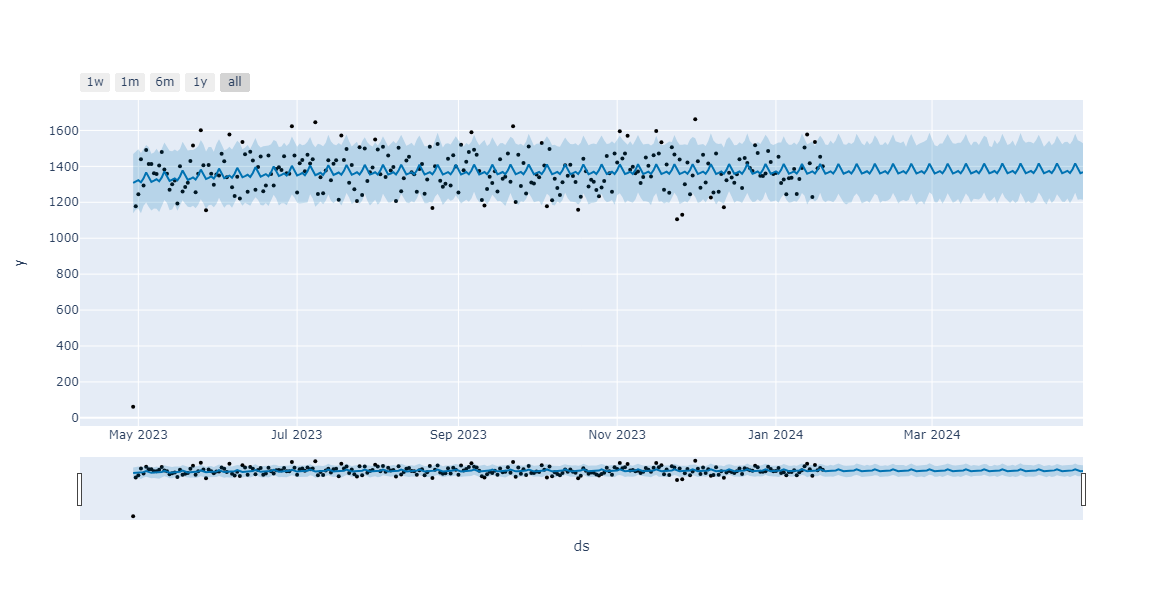

In [50]:
plot_plotly(m, forecast)

#### Evaluation Your model

In [51]:
from statsmodels.tools.eval_measures import rmse

In [52]:
predictions = forecast.iloc[-100:]['yhat']

In [53]:
print('Root Mean Squared Error Between Actual and Predicted values: ', rmse(predictions, test['y']))
print('Mean value of Test data: ', test['y'].mean())

Root Mean Squared Error Between Actual and Predicted values:  90.97489509265888
Mean value of Test data:  1371.04


# Exponential Smoothing

#### Predict the test_data

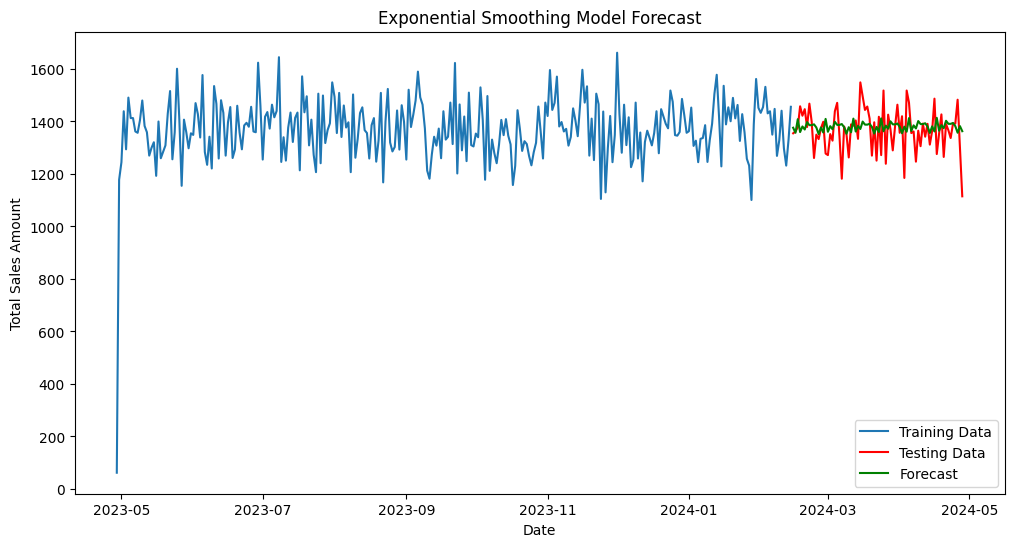

In [54]:
# Fit Exponential Smoothing model
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Exponential Smoothing model
model_ets = ExponentialSmoothing(train_data['Total Sales'], trend='add', seasonal='add', seasonal_periods=12)
results_ets = model_ets.fit()
# implies a constant increment or decrement over time. For example, if sales increase by a fixed amount each period, the trend is additive.

# Predict the test data
forecast_ets = results_ets.forecast(steps=len(test_data))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train_data['Total Sales'], label='Training Data')
plt.plot(test_data['Total Sales'], label='Testing Data', color='red')
plt.plot(test_data.index, forecast_ets, label='Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.title('Exponential Smoothing Model Forecast')
plt.legend()
plt.show()

In [55]:
# actual test data
test_data.head()

Total Sales
Date                   
2024-02-15         1355
2024-02-16         1362
2024-02-17         1378
2024-02-18         1458
2024-02-19         1422

In [56]:
# predicted test data
forecast_ets

2024-02-15    1376.258818
2024-02-16    1356.992580
2024-02-17    1408.937542
2024-02-18    1359.756857
2024-02-19    1381.145195
                 ...     
2024-04-24    1394.306557
2024-04-25    1382.308642
2024-04-26    1357.217431
2024-04-27    1382.360776
2024-04-28    1363.094539
Freq: D, Length: 74, dtype: float64

#### Calculate Metrics

In [57]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Assume y_true and y_pred are the actual and predicted values respectively
y_true = test_data['Total Sales']
y_pred = forecast_ets  # Replace with the predictions from your model

# Calculate MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate MSE
mse = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate MAPE
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%')

Mean Absolute Error (MAE): 66.02999848391899
Mean Squared Error (MSE): 7428.854464187992
Root Mean Squared Error (RMSE): 86.19080266587608
Mean Absolute Percentage Error (MAPE): 4.95%


#### forecasting 30 days sales

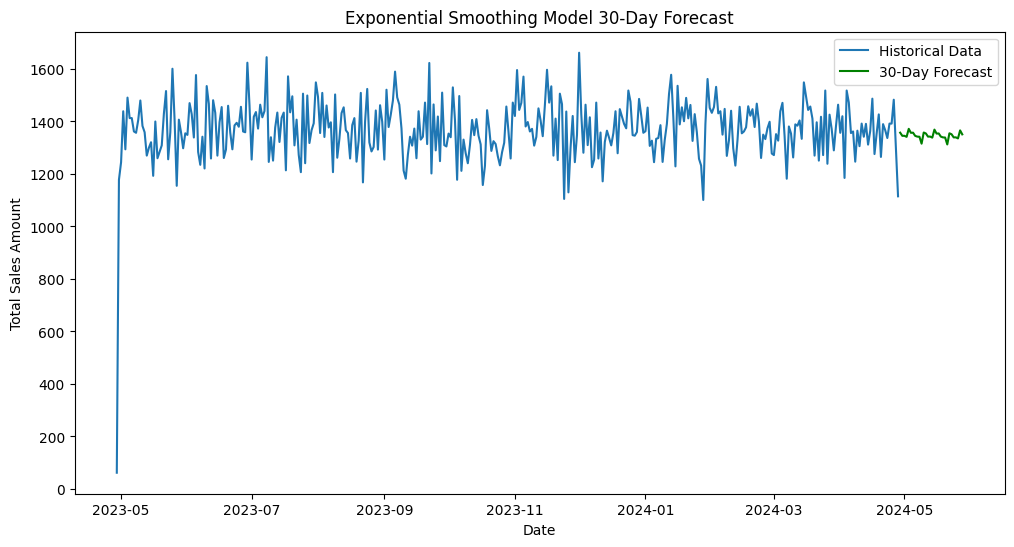

In [58]:
# Fit Exponential Smoothing model
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Exponential Smoothing model
model_ets = ExponentialSmoothing(sales_data, trend='add', seasonal='add', seasonal_periods=12)
results_ets = model_ets.fit()

# Forecast the next 30 days
forecast_steps = 30
forecast_ets = results_ets.forecast(steps=forecast_steps)

# Create a new index for the forecast period
last_date = sales_data.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(sales_data['Total Sales'], label='Historical Data')
plt.plot(forecast_dates, forecast_ets, label='30-Day Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.title('Exponential Smoothing Model 30-Day Forecast')
plt.legend()
plt.show()

In [59]:
# forecasting 30 sales
forecast_ets

2024-04-29    1357.356422
2024-04-30    1345.392700
2024-05-01    1345.510114
2024-05-02    1341.501746
2024-05-03    1372.061291
2024-05-04    1356.916686
2024-05-05    1357.429781
2024-05-06    1345.347171
2024-05-07    1342.410616
2024-05-08    1341.869006
2024-05-09    1315.545605
2024-05-10    1358.076651
2024-05-11    1354.385099
2024-05-12    1342.421377
2024-05-13    1342.538790
2024-05-14    1338.530422
2024-05-15    1369.089968
2024-05-16    1353.945362
2024-05-17    1354.458458
2024-05-18    1342.375847
2024-05-19    1339.439292
2024-05-20    1338.897682
2024-05-21    1312.574282
2024-05-22    1355.105327
2024-05-23    1351.413775
2024-05-24    1339.450053
2024-05-25    1339.567467
2024-05-26    1335.559099
2024-05-27    1366.118644
2024-05-28    1350.974039
Freq: D, dtype: float64

# Random Forest:

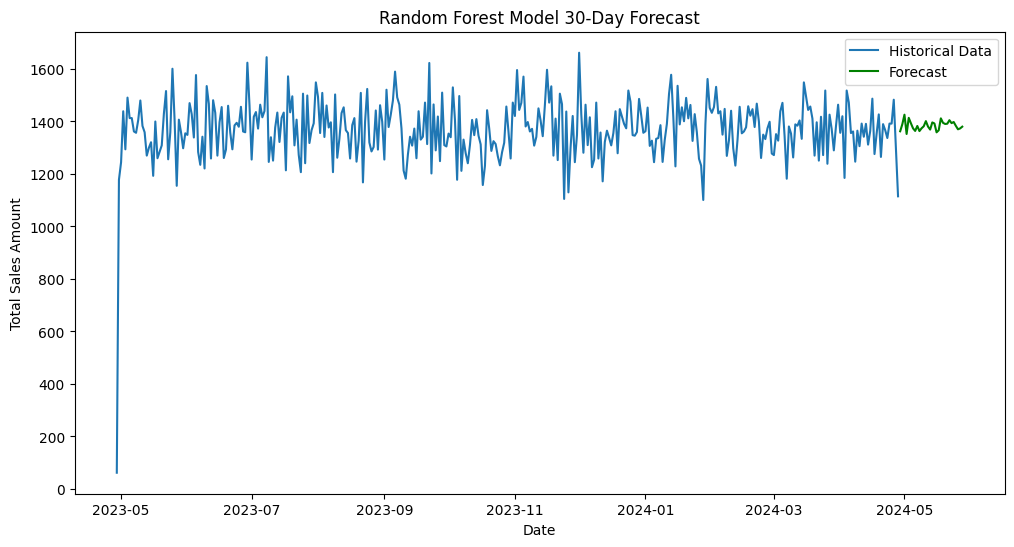

In [60]:
from sklearn.ensemble import RandomForestRegressor
# Function to create lag features
def create_lag_features(data, lag):
    df = sales_data.copy()
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['Total Sales'].shift(i)
    return df

# Create lag features
lag = 30
sales_data_lagged = create_lag_features(sales_data, lag)
sales_data_lagged.dropna(inplace=True)

# Split data into train and test sets
split_ratio = 0.8
split_point = int(len(sales_data_lagged) * split_ratio)
train_data = sales_data_lagged[:split_point]
test_data = sales_data_lagged[split_point:]

# Features and target
X_train = train_data.drop(columns=['Total Sales'])
y_train = train_data['Total Sales']
X_test = test_data.drop(columns=['Total Sales'])
y_test = test_data['Total Sales']

# Train Random Forest model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Forecast the next 30 days
# For forecasting, we need to iteratively predict the next value and create new features
last_known_values = sales_data_lagged.iloc[-lag:]['Total Sales'].values
predictions = []

for i in range(30):
    X_new = last_known_values[-lag:].reshape(1, -1)
    y_new = model_rf.predict(X_new)[0]
    predictions.append(y_new)
    last_known_values = np.append(last_known_values, y_new)[1:]

# Create a new index for the forecast period
last_date = sales_data.index[-1]
forecast_dates = pd.date_range(start=last_date, periods=30 + 1, freq='D')[1:]

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(sales_data['Total Sales'], label='Historical Data')
plt.plot(forecast_dates, predictions, label='Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.title('Random Forest Model 30-Day Forecast')
plt.legend()
plt.show()

In [61]:
# feature 30 days forecasting
predictions

[1362.76,
 1389.55,
 1425.87,
 1352.49,
 1413.94,
 1393.51,
 1373.95,
 1364.08,
 1382.95,
 1363.51,
 1374.16,
 1381.77,
 1401.43,
 1380.76,
 1369.23,
 1396.51,
 1392.47,
 1358.72,
 1366.53,
 1411.93,
 1394.96,
 1390.62,
 1391.45,
 1404.95,
 1393.82,
 1398.04,
 1383.54,
 1370.29,
 1373.6,
 1380.29]

In [62]:
test_data.head()

Total Sales   lag_1   lag_2   lag_3   lag_4   lag_5   lag_6  \
Date                                                                      
2024-02-21         1379  1447.0  1422.0  1458.0  1378.0  1362.0  1355.0   
2024-02-22         1468  1379.0  1447.0  1422.0  1458.0  1378.0  1362.0   
2024-02-23         1399  1468.0  1379.0  1447.0  1422.0  1458.0  1378.0   
2024-02-24         1261  1399.0  1468.0  1379.0  1447.0  1422.0  1458.0   
2024-02-25         1350  1261.0  1399.0  1468.0  1379.0  1447.0  1422.0   

             lag_7   lag_8   lag_9  ...  lag_21  lag_22  lag_23  lag_24  \
Date                                ...                                   
2024-02-21  1456.0  1330.0  1232.0  ...  1452.0  1562.0  1390.0  1101.0   
2024-02-22  1355.0  1456.0  1330.0  ...  1433.0  1452.0  1562.0  1390.0   
2024-02-23  1362.0  1355.0  1456.0  ...  1455.0  1433.0  1452.0  1562.0   
2024-02-24  1378.0  1362.0  1355.0  ...  1532.0  1455.0  1433.0  1452.0   
2024-02-25  1458.0  1378.0  1362.0  ...  1431.0  1532.0  1455.0  1433.0   

            lag_25  lag_26  lag_27  lag_28  lag_29  lag_30  
Date                                                        
2024-02-21  1232.0  1258.0  1359.0  1428.0  1326.0  1463.0  
2024-02-22  1101.0  1232.0  1258.0  1359.0  1428.0  1326.0  
2024-02-23  1390.0  1101.0  1232.0  1258.0  1359.0  1428.0  
2024-02-24  1562.0  1390.0  1101.0  1232.0  1258.0  1359.0  
2024-02-25  1452.0  1562.0  1390.0  1101.0  1232.0  1258.0  

[5 rows x 31 columns]

In [63]:
y_test_predict = model_rf.predict(X_test)
y_test_predict

array([1381.94, 1422.23, 1420.06, 1338.06, 1375.62, 1376.46, 1343.05,
       1356.45, 1367.06, 1366.69, 1358.48, 1385.91, 1375.26, 1380.  ,
       1414.1 , 1420.1 , 1431.65, 1401.19, 1385.44, 1394.11, 1360.37,
       1367.29, 1387.12, 1378.31, 1369.46, 1364.4 , 1421.93, 1366.  ,
       1386.6 , 1405.04, 1385.55, 1363.81, 1383.41, 1333.19, 1363.19,
       1400.76, 1378.41, 1401.21, 1392.24, 1356.39, 1376.51, 1422.3 ,
       1402.76, 1375.9 , 1361.28, 1359.35, 1345.33, 1390.97, 1371.08,
       1370.4 , 1369.26, 1377.06, 1379.56, 1374.51, 1361.41, 1385.88,
       1381.01, 1409.44, 1359.76, 1395.93, 1398.85, 1392.02, 1380.86,
       1404.81, 1374.71, 1336.54, 1403.37, 1369.59])

In [64]:
y_test

Date
2024-02-21    1379
2024-02-22    1468
2024-02-23    1399
2024-02-24    1261
2024-02-25    1350
              ... 
2024-04-24    1392
2024-04-25    1392
2024-04-26    1483
2024-04-27    1301
2024-04-28    1115
Name: Total Sales, Length: 68, dtype: int64

#### Calculate Metrics

In [65]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Assume y_true and y_pred are the actual and predicted values respectively
y_true = y_test
y_pred = y_test_predict  # Replace with the predictions from your model

# Calculate MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate MSE
mse = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate MAPE
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%')


Mean Absolute Error (MAE): 69.48426470588234
Mean Squared Error (MSE): 8322.730595588233
Root Mean Squared Error (RMSE): 91.22900084725379
Mean Absolute Percentage Error (MAPE): 5.22%


#### 2. How will the dataset be split into training and testing sets for model evaluation?

Here’s how the dataset will be split:

##### Training Set: This set will contain the first portion of the time series data. It is used to train the model.

##### Test Set: This set will contain the latter portion of the time series data. It is used to evaluate the model's performance by comparing the predicted values with the actual values.

#### Steps for Splitting the Data

##### Determine the Split Ratio: 
Typically, a common practice is to use an 80/20 split, where 80% of the data is used for training and 20% is used for testing. However, this ratio can be adjusted based on the dataset size and specific requirements.

Split the Data: Use the determined split ratio to separate the data into training and test sets.



In [66]:
# Assuming daily_sales_df is the DataFrame with 'Date' as index and 'TotalAmount' as the column

# Determine the split point
split_ratio = 0.8
split_point = int(len(sales_data) * split_ratio)

# Split the data into training and test sets
train, test = sales_data.iloc[:split_point], sales_data.iloc[split_point:]

# Print the lengths to verify
print(f"Training set length: {len(train)}")
print(f"Test set length: {len(test)}")

Training set length: 292
Test set length: 74


Mean Absolute Error (MAE): 66.02999848391899
Mean Squared Error (MSE): 7428.854464187992
Root Mean Squared Error (RMSE): 86.19080266587608
Mean Absolute Percentage Error (MAPE): 4.95%


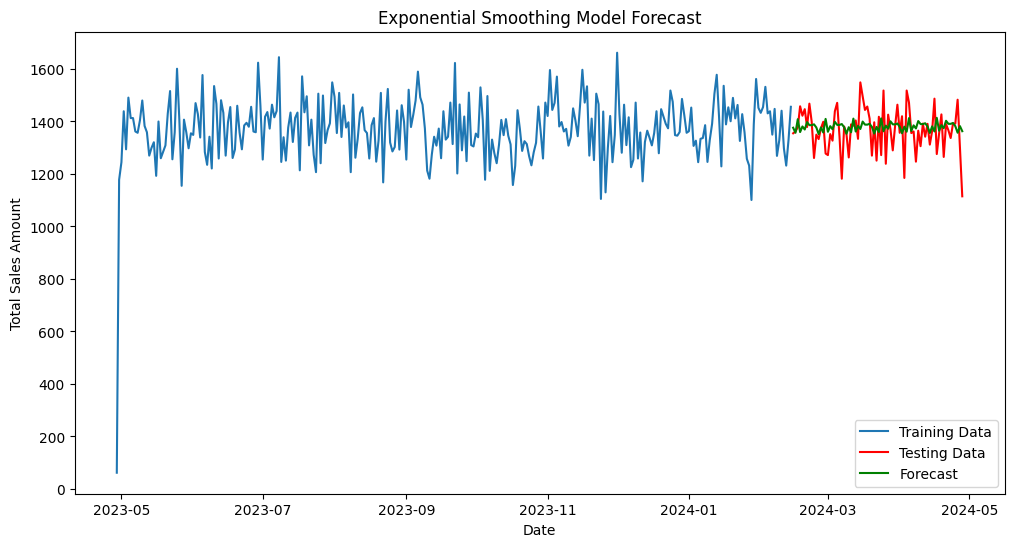

Backtest Mean Absolute Error (MAE): 68.361822270849
Backtest Mean Squared Error (MSE): 7804.5307342685965
Backtest Root Mean Squared Error (RMSE): 88.34325517134059
Backtest Mean Absolute Percentage Error (MAPE): 5.10%


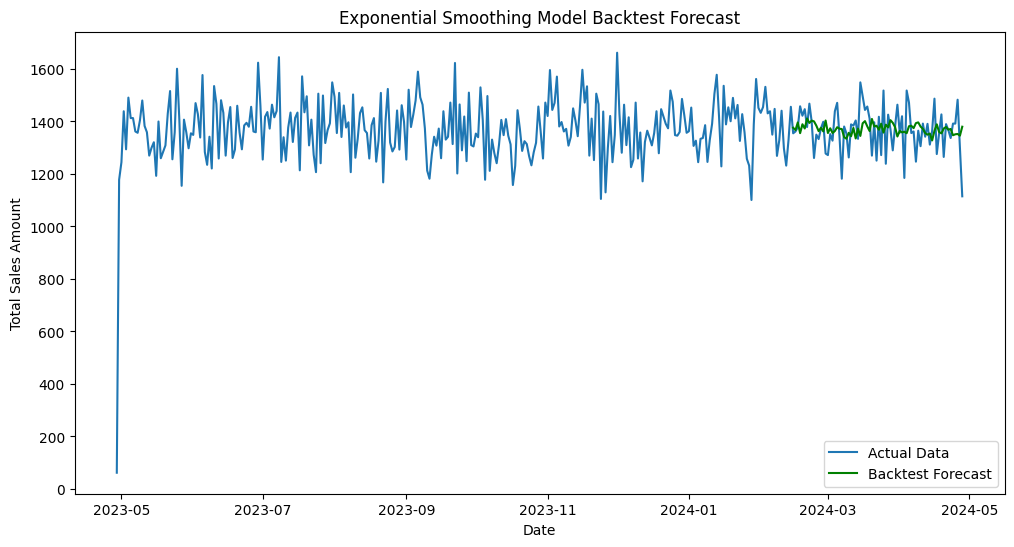

In [67]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# Load the data
# sales_data = pd.read_csv('/mnt/data/Retail_Transaction_Dataset 1.csv', index_col='TransactionDate', parse_dates=True)

# Split data into train and test sets
split_ratio = 0.8
split_point = int(len(sales_data) * split_ratio)
train_data = sales_data[:split_point]
test_data = sales_data[split_point:]

# Fit Exponential Smoothing model
model_ets = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=12)
results_ets = model_ets.fit()

# Predict the test data
forecast_ets = results_ets.forecast(steps=len(test_data))

# Calculate evaluation metrics
mae = mean_absolute_error(test_data, forecast_ets)
mse = mean_squared_error(test_data, forecast_ets)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_data, forecast_ets)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Testing Data', color='red')
plt.plot(test_data.index, forecast_ets, label='Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.title('Exponential Smoothing Model Forecast')
plt.legend()
plt.show()

# Backtesting with Walk-Forward Validation
def walk_forward_validation(data, n_test, model_func, **kwargs):
    predictions = []
    train, test = data[:-n_test], data[-n_test:]
    history = list(train)
    for i in range(len(test)):
        model = model_func(history, **kwargs)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=1)
        predictions.append(yhat[0])
        history.append(test[i])
    return test, predictions

sales_data['Total Sales'] = pd.to_numeric(sales_data['Total Sales'], errors='coerce')

# Example of using the function
n_test = len(test_data)
test, predictions = walk_forward_validation(sales_data['Total Sales'], n_test, ExponentialSmoothing, trend='add', seasonal='add', seasonal_periods=12)

# Evaluate backtest
mae_backtest = mean_absolute_error(test, predictions)
mse_backtest = mean_squared_error(test, predictions)
rmse_backtest = np.sqrt(mse_backtest)
mape_backtest = mean_absolute_percentage_error(test, predictions)

print(f'Backtest Mean Absolute Error (MAE): {mae_backtest}')
print(f'Backtest Mean Squared Error (MSE): {mse_backtest}')
print(f'Backtest Root Mean Squared Error (RMSE): {rmse_backtest}')
print(f'Backtest Mean Absolute Percentage Error (MAPE): {mape_backtest * 100:.2f}%')

# Plot backtest results
plt.figure(figsize=(12, 6))
plt.plot(sales_data.index, sales_data.values, label='Actual Data')
plt.plot(test_data.index, predictions, label='Backtest Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.title('Exponential Smoothing Model Backtest Forecast')
plt.legend()
plt.show()

In [68]:
df.head()

CustomerID ProductID  Quantity      Price     TransactionDate  \
0      109318         C         7  80.079844 2023-12-26 12:32:00   
1      993229         C         4  75.195229 2023-08-05 00:00:00   
2      579675         A         8  31.528816 2024-03-11 18:51:00   
3      799826         D         5  98.880218 2023-10-27 22:00:00   
4      121413         A         7  93.188512 2023-12-22 11:38:00   

  PaymentMethod                                      StoreLocation  \
0          Cash            176 Andrew Cliffs\nBaileyfort, HI 93354   
1          Cash  11635 William Well Suite 809\nEast Kara, MT 19483   
2          Cash  910 Mendez Ville Suite 909\nPort Lauraland, MO...   
3        PayPal  87522 Sharon Corners Suite 500\nLake Tammy, MO...   
4          Cash   0070 Michelle Island Suite 143\nHoland, VA 80142   

  ProductCategory  DiscountApplied(%)  TotalAmount            City State  \
0           Books           18.677100   455.862764      Baileyfort    HI   
1      Home Decor           14.121365   258.306546       East Kara    MT   
2           Books           15.943701   212.015651  Port Lauraland    MO   
3           Books            6.686337   461.343769      Lake Tammy    MO   
4     Electronics            4.030096   626.030484          Holand    VA   

         Date  
0  2023-12-26  
1  2023-08-05  
2  2024-03-11  
3  2023-10-27  
4  2023-12-22

In [69]:
new_df.head()

Total Sales
Date                   
2023-04-29           62
2023-04-30         1178
2023-05-01         1245
2023-05-02         1439
2023-05-03         1294

In [70]:
df.head()

CustomerID ProductID  Quantity      Price     TransactionDate  \
0      109318         C         7  80.079844 2023-12-26 12:32:00   
1      993229         C         4  75.195229 2023-08-05 00:00:00   
2      579675         A         8  31.528816 2024-03-11 18:51:00   
3      799826         D         5  98.880218 2023-10-27 22:00:00   
4      121413         A         7  93.188512 2023-12-22 11:38:00   

  PaymentMethod                                      StoreLocation  \
0          Cash            176 Andrew Cliffs\nBaileyfort, HI 93354   
1          Cash  11635 William Well Suite 809\nEast Kara, MT 19483   
2          Cash  910 Mendez Ville Suite 909\nPort Lauraland, MO...   
3        PayPal  87522 Sharon Corners Suite 500\nLake Tammy, MO...   
4          Cash   0070 Michelle Island Suite 143\nHoland, VA 80142   

  ProductCategory  DiscountApplied(%)  TotalAmount            City State  \
0           Books           18.677100   455.862764      Baileyfort    HI   
1      Home Decor           14.121365   258.306546       East Kara    MT   
2           Books           15.943701   212.015651  Port Lauraland    MO   
3           Books            6.686337   461.343769      Lake Tammy    MO   
4     Electronics            4.030096   626.030484          Holand    VA   

         Date  
0  2023-12-26  
1  2023-08-05  
2  2024-03-11  
3  2023-10-27  
4  2023-12-22

In [71]:
df.describe()

CustomerID       Quantity          Price  \
count  100000.000000  100000.000000  100000.000000   
mean   500463.982180       5.009290      55.067344   
min        14.000000       1.000000      10.000430   
25%    250693.750000       3.000000      32.549474   
50%    499679.000000       5.000000      55.116789   
75%    751104.750000       7.000000      77.456763   
max    999997.000000       9.000000      99.999284   
std    288460.917524       2.579808      25.971567   

                     TransactionDate  DiscountApplied(%)    TotalAmount  
count                         100000       100000.000000  100000.000000  
mean   2023-10-29 15:40:05.471399936           10.020155     248.334955  
min              2023-04-29 22:27:00            0.000046       8.274825  
25%              2023-07-30 06:45:15            5.001013      95.163418  
50%              2023-10-30 05:12:30           10.030353     200.368393  
75%              2024-01-29 05:44:00           15.018367     362.009980  
max              2024-04-28 22:22:00           19.999585     896.141242  
std                              NaN            5.779534     184.554792

In [72]:
d = df[['Quantity', 'Price', 'DiscountApplied(%)', 'TotalAmount']]
d.head()

Quantity      Price  DiscountApplied(%)  TotalAmount
0         7  80.079844           18.677100   455.862764
1         4  75.195229           14.121365   258.306546
2         8  31.528816           15.943701   212.015651
3         5  98.880218            6.686337   461.343769
4         7  93.188512            4.030096   626.030484

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   CustomerID          100000 non-null  int64         
 1   ProductID           100000 non-null  object        
 2   Quantity            100000 non-null  int64         
 3   Price               100000 non-null  float64       
 4   TransactionDate     100000 non-null  datetime64[ns]
 5   PaymentMethod       100000 non-null  object        
 6   StoreLocation       100000 non-null  object        
 7   ProductCategory     100000 non-null  object        
 8   DiscountApplied(%)  100000 non-null  float64       
 9   TotalAmount         100000 non-null  float64       
 10  City                89194 non-null   object        
 11  State               89194 non-null   object        
 12  Date                100000 non-null  object        
dtypes: datetime64[ns](1), float64(

In [74]:
df.isna().sum()

CustomerID                0
ProductID                 0
Quantity                  0
Price                     0
TransactionDate           0
PaymentMethod             0
StoreLocation             0
ProductCategory           0
DiscountApplied(%)        0
TotalAmount               0
City                  10806
State                 10806
Date                      0
dtype: int64

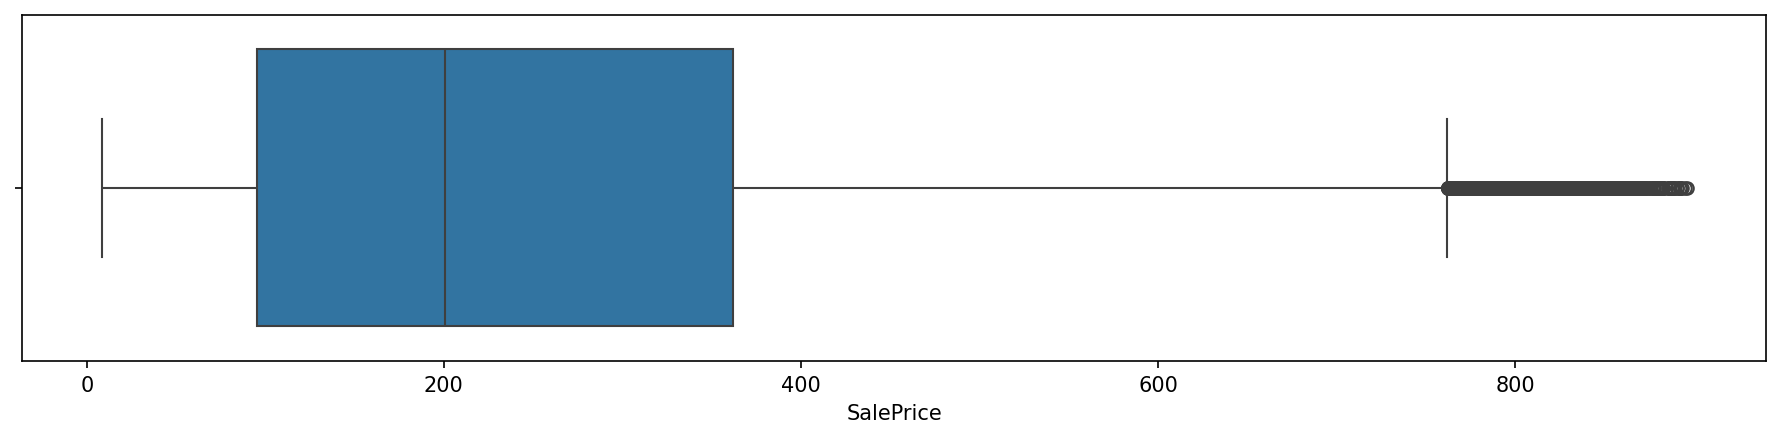

In [75]:
plt.figure(figsize=(15, 3), dpi=150)

# Create the boxplot
sns.boxplot(x=df['TotalAmount'])

# Set the plot orientation
plt.xlabel('SalePrice')

# Show the plot
plt.show()

ValueError: could not convert string to float: 'C'

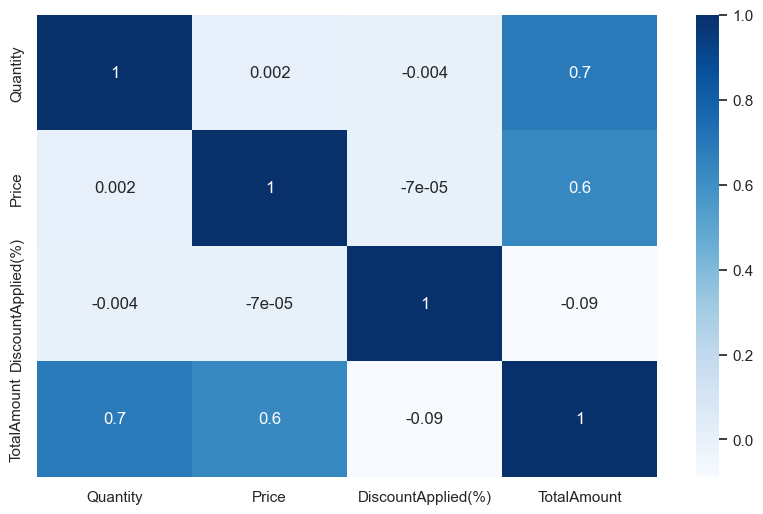

In [76]:
plt.figure(figsize=(10,6))
sns.set_theme(style="white")
corr = d.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')
sns.heatmap(df.corr())

In [ ]:
df.head()

In [ ]:
data =df.TotalAmount

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Histogram
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(data, kde=True)
plt.title('Histogram')

In [ ]:
plt.subplot(1, 2, 2)
stats.probplot(data, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()